In [ ]:
# Install necessary packages if not already installed
!pip install cooler
!pip install cooltools
!pip install bioframe
!pip install pysam

In [2]:
# Import standard python libraries (assumed already installed, if not then 
# install first)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, subprocess
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
import bioframe
import pysam
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from cooltools import insulation

In [3]:
# Examines control (fly.mcool) and heat shock (fly_hs.mcool) Hi-C datasets for 
# Drosophila melanogaster
# Saves fly.mcool as clr and fly_hs.mcool as clr_hs
# Loads at 100 kb resolution
resolution = 100000
clr = cooler.Cooler('fly.mcool::resolutions/'+str(resolution))
clr_hs = cooler.Cooler('fly_hs.mcool::resolutions/'+str(resolution))

In [4]:
# Sorts clr and clr_hs into bins (100 kb)
bins = clr.bins()[:]
bins_hs = clr_hs.bins()[:]

# Loads dm6.fa file into fly_genome.  Obtained from http://genome.ucsc.edu/.
fly_genome = bioframe.load_fasta('./dm6.fa');

# Calculate the fraction of GC basepairs in each bin
# Redundant variable created but may be useful for future testing of alternative
# phasing tracks
gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], fly_genome)
gc_cov_hs = bioframe.frac_gc(bins_hs[['chrom', 'start', 'end']], fly_genome)

# Converts tsv files just produced into csv files
gc_cov.to_csv('fly_gc_cov_100kb.tsv',index=False,sep='\t')
gc_cov_hs.to_csv('fly_gc_cov_hs_100kb.tsv',index=False,sep='\t')

In [5]:
# Creates dataframe showing start and end of chromosome
view_df = pd.DataFrame({'chrom': clr.chromnames,
                        'start': 0,
                        'end': clr.chromsizes.values,
                        'name': clr.chromnames}
                      )
view_df_hs = pd.DataFrame({'chrom': clr_hs.chromnames,
                        'start': 0,
                        'end': clr_hs.chromsizes.values,
                        'name': clr_hs.chromnames}
                      )
display(view_df)
display(view_df_hs)

view_df.equals(view_df_hs)

,chrom,start,end,name
0,chr2L,0,23513712,chr2L
1,chr2R,0,25286936,chr2R
2,chr3L,0,28110227,chr3L
3,chr3R,0,32079331,chr3R
4,chr4,0,1348131,chr4
5,chrX,0,23542271,chrX
6,chrY,0,3667352,chrY


,chrom,start,end,name
0,chr2L,0,23513712,chr2L
1,chr2R,0,25286936,chr2R
2,chr3L,0,28110227,chr3L
3,chr3R,0,32079331,chr3R
4,chr4,0,1348131,chr4
5,chrX,0,23542271,chrX
6,chrY,0,3667352,chrY


True

In [6]:
# Obtains first eigenvector (E1), assumed to represent compartment score for all
# chromosomes
cis_eigs = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=1,
                        )
cis_eigs_hs = cooltools.eigs_cis(
                        clr_hs,
                        gc_cov_hs,
                        view_df=view_df_hs,
                        n_eigs=1,
                        )
# cis_eigs[0] returns eigenvalues, cis_eigs[1] returns eigenvectors
eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]
eigenvector_track_hs = cis_eigs_hs[1][['chrom','start','end','E1']]

In [7]:
# Start and stop for each chromosome (100kb resolution)
chromosomes = list(view_df['chrom'])
controlIndicies = []
for chr in chromosomes:
  test = eigenvector_track.index[eigenvector_track['chrom']==chr]
  controlIndicies.append((min(test),max(test)+1))
controlIndicies

[(0, 236),
 (236, 489),
 (489, 771),
 (771, 1092),
 (1092, 1106),
 (1106, 1342),
 (1342, 1379)]

In [8]:
# Intrachromosomal Interactions

# Function to generate heatmap and E1 plot
def plotData(index, cool, eigs):
  f, ax = plt.subplots(
    figsize=(15, 10),)
  norm = LogNorm(vmax=0.1)

  im = ax.matshow(
      cool.matrix()[:],
      norm=norm,
      cmap='fall'
  );
  plt.axis([index[0],index[1],index[1],index[0]])

  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.1)
  plt.colorbar(im, cax=cax, label='corrected frequencies');
  ax.xaxis.set_visible(False)

  ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
  weights = cool.bins()[:]['weight'].values
  ax1.plot([index[0],index[1]],[0,0],'k',lw=0.25)
  ax1.plot( eigs['E1'].values, label='E1')

  ax1.set_ylabel('E1')
  ax1.set_xticks([]);


  for i in np.where(np.diff( (eigs['E1']>0).astype(int)))[0]:
        ax.plot([index[0],index[1]],[i,i],'k',lw=0.5) # horizontal lines
        ax.plot([i,i],[index[0], index[1]],'k',lw=0.5) # vertical lines
  return f

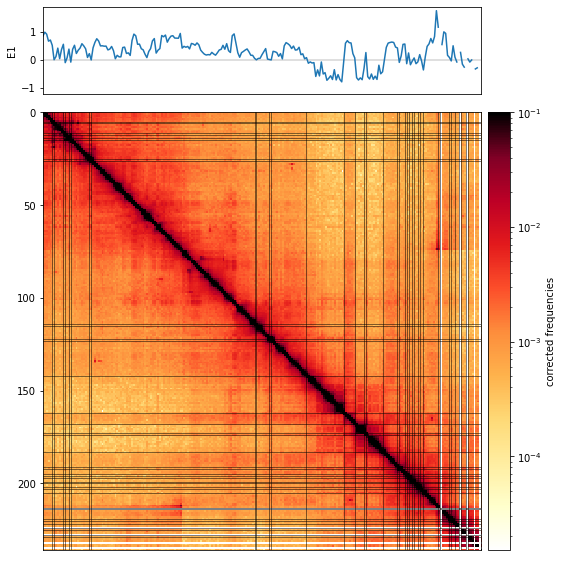

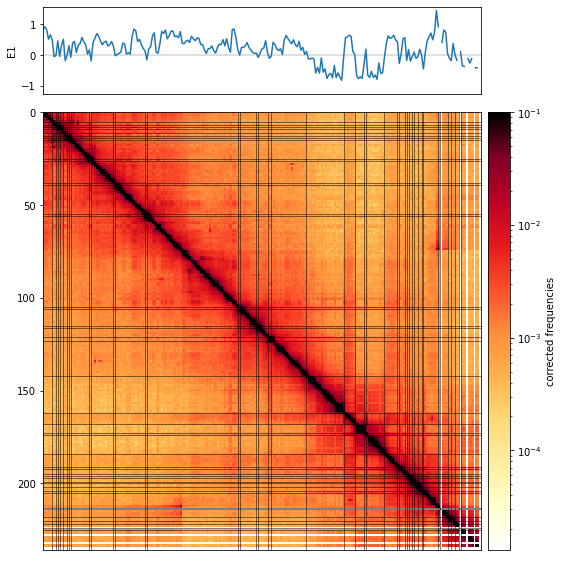

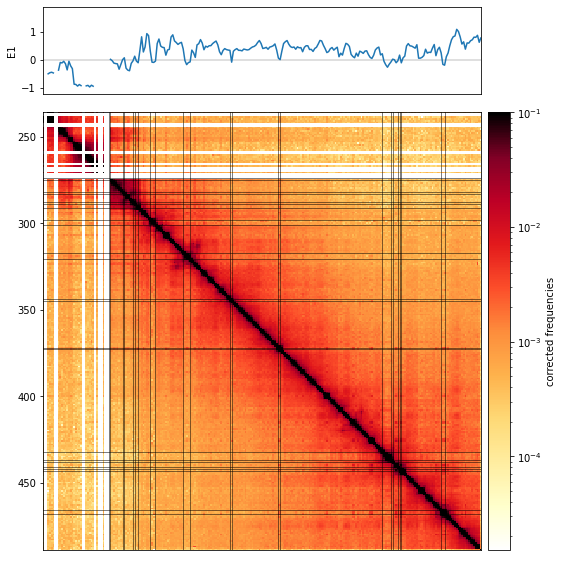

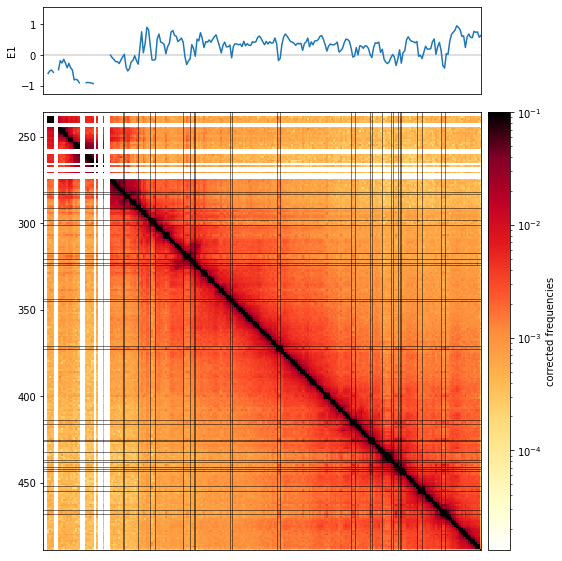

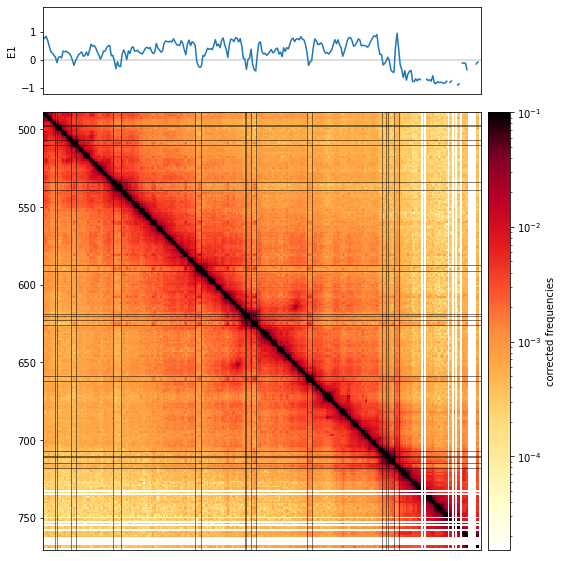

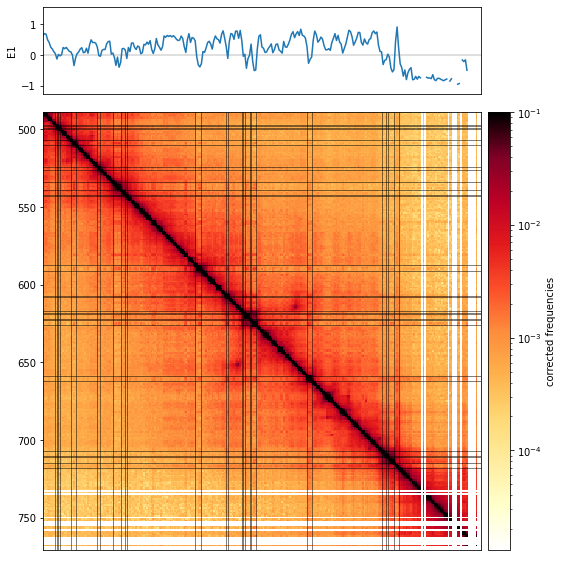

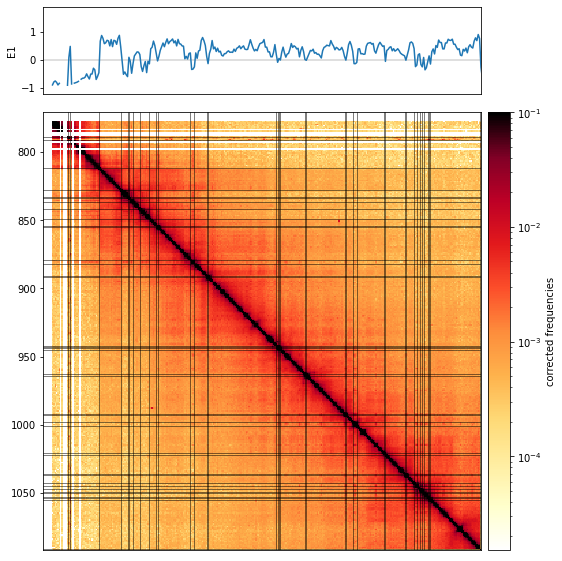

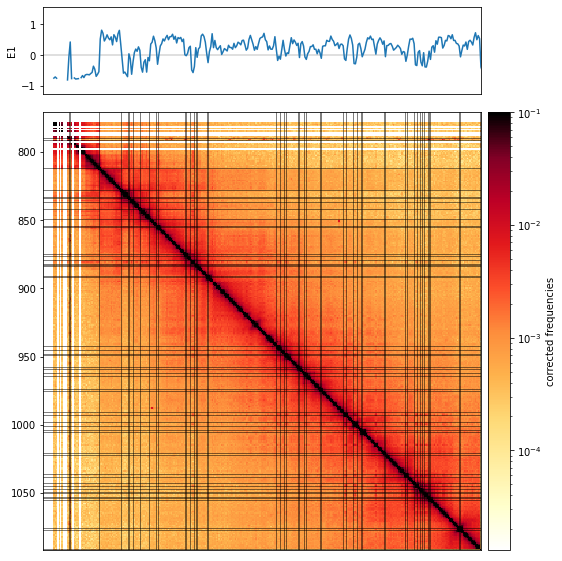

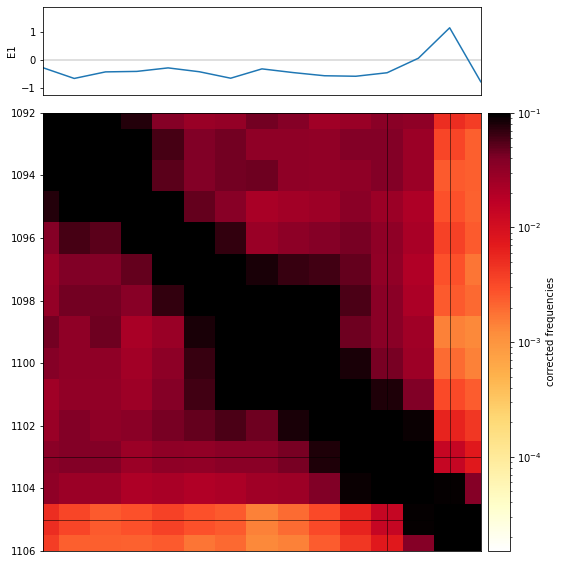

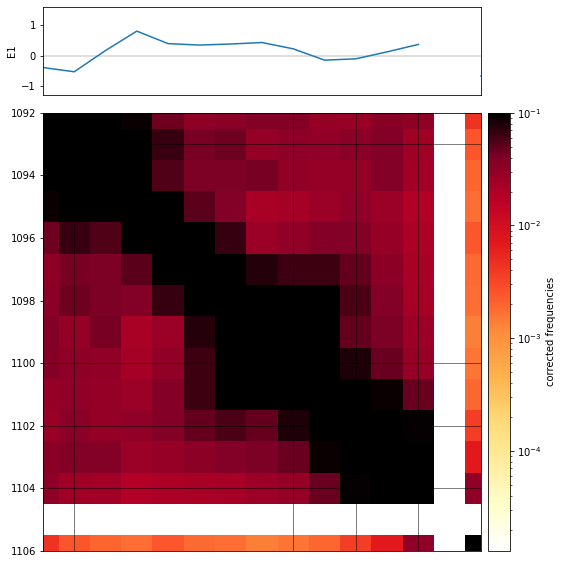

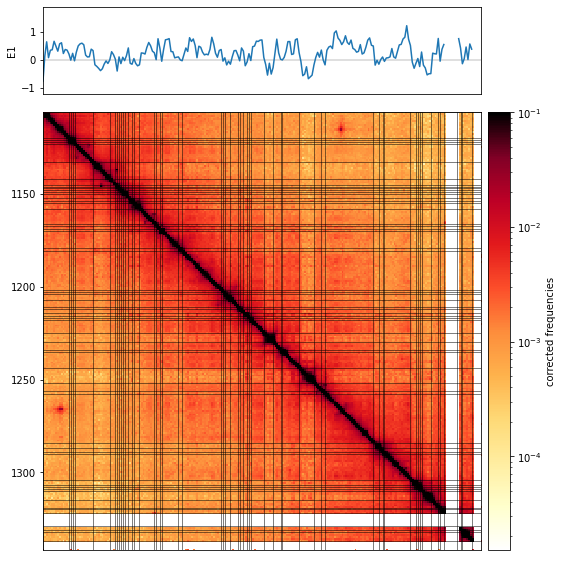

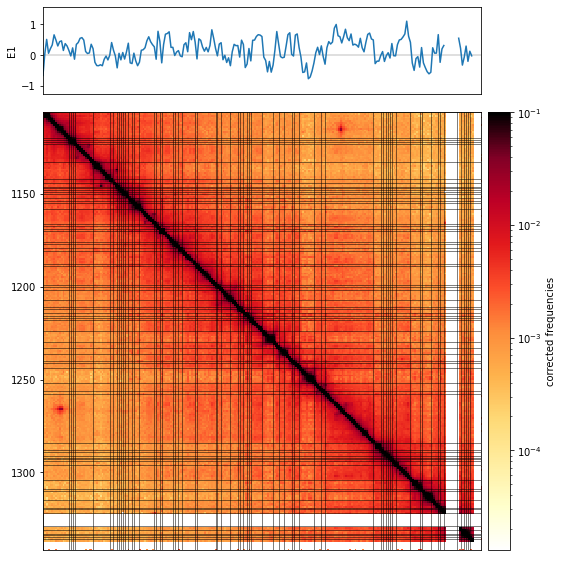

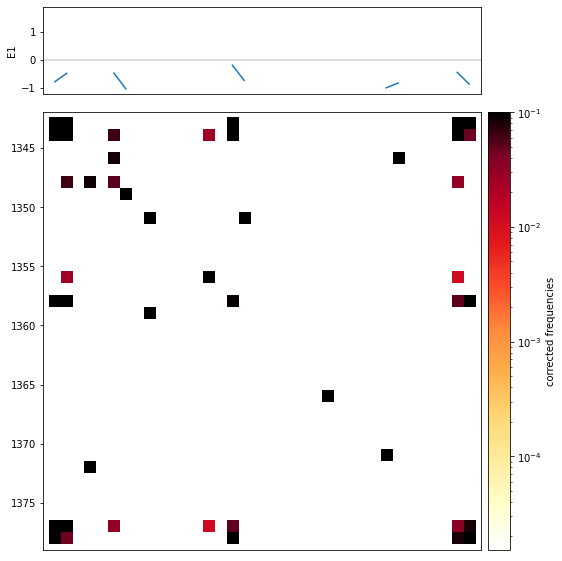

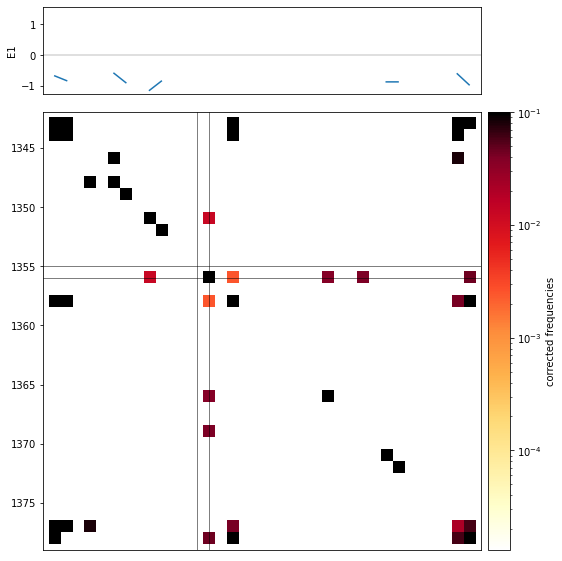

In [9]:
# Runs plot function above for control and HS data
controlGraphs = []
heatshockGraphs = []
for i in controlIndicies:
  controlGraphs.append(plotData(i,clr,eigenvector_track))
  heatshockGraphs.append(plotData(i,clr_hs,eigenvector_track_hs))

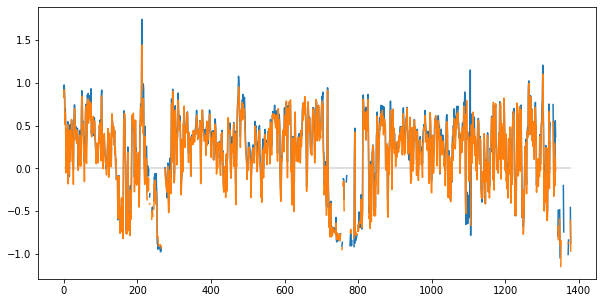

In [10]:
# Overlays HS and control E1 plot for entire genome (intrachromosomal).  
plt.subplots(figsize=(10, 5))
plt.plot([0,1379],[0,0],'k',lw=0.25,)
plt.plot(eigenvector_track["E1"].index,eigenvector_track["E1"].values)
plt.plot(eigenvector_track["E1"].index,eigenvector_track_hs["E1"].values)

(1075.0, 1125.0)

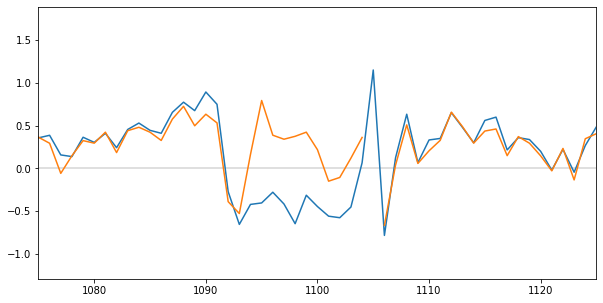

In [11]:
# Zooms in on genome-wide E1 plot (intrachromosomal) at region showning 
# difference in E1 sign
plt.subplots(figsize=(10, 5))
plt.plot([0,1379],[0,0],'k',lw=0.25,)
plt.plot(eigenvector_track["E1"].index,eigenvector_track["E1"].values)
plt.plot(eigenvector_track["E1"].index,eigenvector_track_hs["E1"].values)
plt.xlim([1075,1125])

In [12]:
# Interchromosomal Interactions

# Calculates E1 values for interchromosomal interactions
trans_eigs =cooltools.eigs_trans(clr, phasing_track=None, n_eigs=1)
trans_eigs_hs =cooltools.eigs_trans(clr_hs, phasing_track=None, n_eigs=1)
eigenvector_track_trans = trans_eigs[1][['chrom','start','end','E1']]
eigenvector_track_trans_hs = trans_eigs_hs[1][['chrom','start','end','E1']]

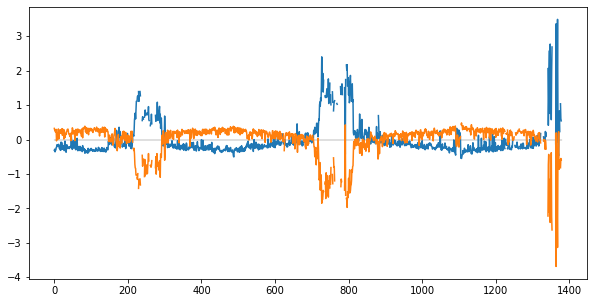

In [13]:
# Overlays HS and control E1 plot for entire genome (interchromosomal).  
plt.subplots(figsize=(10, 5))
plt.plot([0,1379],[0,0],'k',lw=0.25,)
plt.plot(eigenvector_track_trans["E1"].index,eigenvector_track_trans["E1"].values)
plt.plot(eigenvector_track_trans_hs["E1"].index,eigenvector_track_trans_hs["E1"].values)

In [ ]:
# TAD Boundary Determination

# Calculates potential boundaries
# Creates windows to view boundary histogram
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
insulation_table = insulation(clr, windows, verbose=True)
insulation_table_hs = insulation(clr_hs, windows, verbose=True)

In [15]:
# Table of potential boundaries
first_window_summary =insulation_table.columns[[ str(windows[-1]) in i for i in insulation_table.columns]]
insulation_table[['chrom','start','end','region','is_bad_bin']+list(first_window_summary)]

,chrom,start,end,region,is_bad_bin,log2_insulation_score_2500000,n_valid_pixels_2500000,boundary_strength_2500000,is_boundary_2500000
0,chr2L,0,100000,chr2L,False,1.135923,23.0,NaN,False
1,chr2L,100000,200000,chr2L,False,1.064648,47.0,NaN,False
2,chr2L,200000,300000,chr2L,False,1.060027,72.0,NaN,False
3,chr2L,300000,400000,chr2L,False,1.005924,97.0,NaN,False
4,chr2L,400000,500000,chr2L,False,0.886423,122.0,NaN,False
...,...,...,...,...,...,...,...,...,...
1374,chrY,3200000,3300000,chrY,False,NaN,78.0,NaN,False
1375,chrY,3300000,3400000,chrY,True,NaN,57.0,NaN,False
1376,chrY,3400000,3500000,chrY,False,NaN,55.0,NaN,False
1377,chrY,3500000,3600000,chrY,False,NaN,35.0,NaN,False


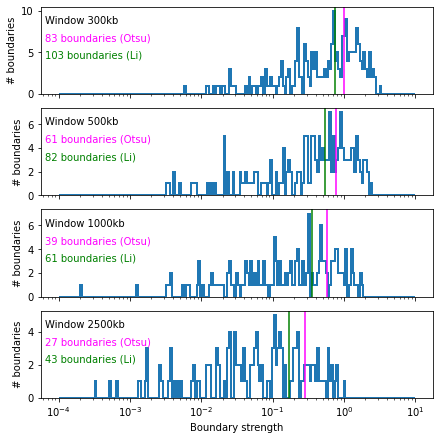

In [16]:
# Control boundary histogram
# Otsu and Li thresholding to determine true boundaries

histkwargs = dict(
bins=10**np.linspace(-4,1,200),
histtype='step',
lw=2,
)

from skimage.filters import threshold_li, threshold_otsu
f, axs = plt.subplots(len(windows), 1, sharex=True, figsize=(6,6), constrained_layout=True)
thresholds_li = {}
thresholds_otsu = {}
for i, (w, ax) in enumerate(zip(windows, axs)):
  ax.hist(
    insulation_table[f'boundary_strength_{w}'],
    **histkwargs
  )
  thresholds_li[w] = threshold_li(insulation_table[f'boundary_strength_{w}'].dropna().values)
  thresholds_otsu[w] = threshold_otsu(insulation_table[f'boundary_strength_{w}'].dropna().values)
  n_boundaries_li = (insulation_table[f'boundary_strength_{w}'].dropna()>=thresholds_li[w]).sum()
  n_boundaries_otsu = (insulation_table[f'boundary_strength_{w}'].dropna()>=thresholds_otsu[w]).sum()
  ax.axvline(thresholds_li[w], c='green')
  ax.axvline(thresholds_otsu[w], c='magenta')
  ax.text(0.01, 0.9,
          f'Window {w//1000}kb',
          ha='left',
          va='top',
          transform=ax.transAxes)
  ax.text(0.01, 0.7,
          f'{n_boundaries_otsu} boundaries (Otsu)',
          c='magenta',
          ha='left',
          va='top',
          transform=ax.transAxes)
  ax.text(0.01, 0.5,
          f'{n_boundaries_li} boundaries (Li)',
          c='green',
          ha='left',
          va='top',
          transform=ax.transAxes)
  ax.set(
      xscale='log',
      ylabel='# boundaries'
  )
  axs[-1].set(xlabel='Boundary strength')

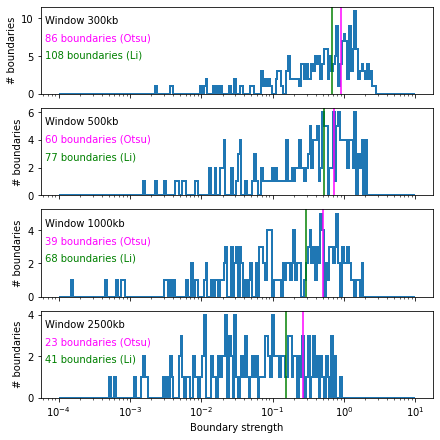

In [17]:
# HS boundary histogram
# Otsu and Li thresholding to determine true boundaries

from skimage.filters import threshold_li, threshold_otsu
f, axs = plt.subplots(len(windows), 1, sharex=True, figsize=(6,6), constrained_layout=True)
thresholds_li = {}
thresholds_otsu = {}
for i, (w, ax) in enumerate(zip(windows, axs)):
  ax.hist(
    insulation_table_hs[f'boundary_strength_{w}'],
    **histkwargs
  )
  thresholds_li[w] = threshold_li(insulation_table_hs[f'boundary_strength_{w}'].dropna().values)
  thresholds_otsu[w] = threshold_otsu(insulation_table_hs[f'boundary_strength_{w}'].dropna().values)
  n_boundaries_li = (insulation_table_hs[f'boundary_strength_{w}'].dropna()>=thresholds_li[w]).sum()
  n_boundaries_otsu = (insulation_table_hs[f'boundary_strength_{w}'].dropna()>=thresholds_otsu[w]).sum()
  ax.axvline(thresholds_li[w], c='green')
  ax.axvline(thresholds_otsu[w], c='magenta')
  ax.text(0.01, 0.9,
          f'Window {w//1000}kb',
          ha='left',
          va='top',
          transform=ax.transAxes)
  ax.text(0.01, 0.7,
          f'{n_boundaries_otsu} boundaries (Otsu)',
          c='magenta',
          ha='left',
          va='top',
          transform=ax.transAxes)
  ax.text(0.01, 0.5,
          f'{n_boundaries_li} boundaries (Li)',
          c='green',
          ha='left',
          va='top',
          transform=ax.transAxes)
  ax.set(
      xscale='log',
      ylabel='# boundaries'
  )
  axs[-1].set(xlabel='Boundary strength')